In [1]:
from OASIS import OASIS
from dataset_loader import load_dataset
from utils import *

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os

In [2]:
def generate_triplets(dataset, num_triplets=201, positive_range=(1, 15), negative_range=(30, 50)):
    """
    Generate triplets for training.

    Args:
    - dataset (array-like): The dataset from which to select images.
    - num_triplets (int): Number of triplets to generate.
    - positive_range (tuple): Range of indices for selecting positive images (start, end).
    - negative_range (tuple): Range of indices for selecting negative images (start, end).

    Returns:
    - triplets (list): List of triplets [anchor, positive, negative].
    """
    anchor_image_indices = []
    selected_positive_list = []
    selected_negative_list = []
    triplets = []

    for _ in range(num_triplets):
        # Randomly choose a new anchor image each iteration
        anchor_index = random.choice(range(len(dataset)))
        anchor_image = dataset[anchor_index]
        anchor_image_indices.append(anchor_index)
        
        # Find 50 nearest images to the anchor
        nearest_indices = np.argsort(vectorized_cosine_distances_normalized(anchor_image, dataset))[:50]
        nearest_to_anchor = [dataset[index] for index in nearest_indices]
        
        # Select positive and negative images
        positive_image = random.choice(nearest_to_anchor[positive_range[0]:positive_range[1]])
        negative_image = random.choice(nearest_to_anchor[negative_range[0]:negative_range[1]])
        
        # Add to lists
        selected_positive_list.append(positive_image)
        selected_negative_list.append(negative_image)
        
        # Create triplet
        triplets.append([anchor_image, positive_image, negative_image])
    
    return triplets

In [3]:
# Specify the directory you want to read from
directory = os.path.join(os.path.dirname(os.getcwd()), 'ViT-L14')

# size = 252001
files_set = [
    '003.txt', '004.txt', '005.txt', 
    '006.txt', '007.txt', '048.txt',
    '049.txt', '055.txt', '056.txt',
    '057.txt'
]

In [4]:
image_names, dataset = load_dataset(directory, files_set)

Processing file: 003.txt
	Number of vectors: 5516
Processing file: 004.txt
	Number of vectors: 8386
Processing file: 005.txt
	Number of vectors: 13638
Processing file: 006.txt
	Number of vectors: 17044
Processing file: 007.txt
	Number of vectors: 15181
Processing file: 048.txt
	Number of vectors: 26687
Processing file: 049.txt
	Number of vectors: 44032
Processing file: 055.txt
	Number of vectors: 43070
Processing file: 056.txt
	Number of vectors: 39764
Processing file: 057.txt
	Number of vectors: 38683

Number of vectors in all files: 252001
Number of dimensions: 768


In [5]:
dataset = np.array(dataset)

## Verification OASIS method after transforming to a symmetric and PSD matrix

In [6]:
triplets = generate_triplets(dataset, num_triplets=100, positive_range=(1, 15), negative_range=(15, 30))
print("END of Generating Triplets")

# Calculate Initial Distances (Euclidean)
initial_distances = []
for anchor, similar, dissimilar in triplets:
    # Euclidean distance to similar
    d_sim = euclidean_distance(anchor, similar)
    # Euclidean distance to dissimilar
    d_dis = euclidean_distance(anchor, dissimilar)
   
    initial_distances.append((d_sim, d_dis))

# Calculate Distances After Training (Mahalanobis)
final_distances = []
for anchor, similar, dissimilar in triplets:
    oasis = OASIS(tau=0.07, enforce_symmetric=True, enforce_psd=True, verbose=False)
    triplet = [[anchor, similar, dissimilar]]  # A single triplet
    oasis.partial_fit(M=np.eye(len(anchor)), triplets=triplet)
    
    M = oasis.get_matrix()
    
    d_sim_mahalanobis = mahalanobis_distance(anchor, similar, M)
    d_dis_mahalanobis = mahalanobis_distance(anchor, dissimilar, M)
    
    final_distances.append((d_sim_mahalanobis, d_dis_mahalanobis))
    
improved_count = 0
failed_count = 0
for (d_sim_initial, d_dis_initial), (d_sim_final, d_dis_final) in zip(initial_distances, final_distances):
    if d_sim_final <= d_sim_initial and d_dis_final >= d_dis_initial:
        improved_count += 1  # Count improved cases
    else:
        print(f"Test failed: d_sim_initial={d_sim_initial}, d_sim_final={d_sim_final}, "
              f"d_dis_initial={d_dis_initial}, d_dis_final={d_dis_final}")
        failed_count += 1  # Count failed cases
        
total_triplets = len(initial_distances)
if failed_count == 0:
    print(f"OASIS method successfully improved all distances!")
    print("For all triplets, similar points were moved closer, and dissimilar points were moved farther.")
else:
    print(f"OASIS method improved {improved_count} out of {total_triplets} distances.")
    print(f"{failed_count} triplets did not improve.")

END of Generating Triplets
OASIS method successfully improved all distances!
For all triplets, similar points were moved closer, and dissimilar points were moved farther.


---

## The Evolution of the Scaling Factor with Increasing User Inputs

In [21]:
M = np.eye(len(dataset[0]))
results = pd.DataFrame(columns=['Num of Inputs', 'Scaling Factor', 'Experiment Type'])

In [22]:
all_results = []
batch = 1

for experiment in range(5):
    # print(f"Experiment {experiment + 1}")
    
    total_num_inputs = 0
    M = np.eye(len(dataset[0]))
    triplets = generate_triplets(dataset, num_triplets=201, positive_range=(1, 15), negative_range=(15, 30))
    # print("Generation finished")
    
    model_oasis = OASIS(tau=0.07, enforce_symmetric=True, enforce_psd=True)
    
    for i in range(1, 201):
        # print(f"Iteration i:{i}")
        start_index = (i - 1) * batch
        end_index = i * batch
        
        num_inputs = batch
        total_num_inputs += batch
        
        triplets_subset = triplets[start_index:end_index]
        
        model_oasis.partial_fit(M, triplets_subset)
        M = model_oasis.get_matrix()
        
        sf = calculate_scaling_factor(M)
        # print(f"Scaling factor of M: {sf}")
        
        result = {
            'Num of Inputs': total_num_inputs,
            'Scaling Factor': format(sf.real, '.6f'),
            'Experiment Type': 'OASIS (Semantic Inputs)'
        }
        
        all_results.append(result)


In [23]:
results = pd.concat([results, pd.DataFrame(all_results)], ignore_index=True)

In [24]:
results.to_pickle('exp_5.pkl')

----

## If you want to only show previous results, start from here

In [25]:
results = pd.read_pickle('exp_5.pkl')

In [26]:
results['Num of Inputs'] = results['Num of Inputs'].astype(int)

filtered_result = results[results['Num of Inputs'] % 10 == 0].copy()
filtered_result

,Num of Inputs,Scaling Factor,Experiment Type
9,10,1.027244,OASIS (Semantic Inputs)
19,20,1.043894,OASIS (Semantic Inputs)
29,30,1.056591,OASIS (Semantic Inputs)
39,40,1.068378,OASIS (Semantic Inputs)
49,50,1.074326,OASIS (Semantic Inputs)
...,...,...,...
959,160,1.117001,OASIS (Semantic Inputs)
969,170,1.118747,OASIS (Semantic Inputs)
979,180,1.128244,OASIS (Semantic Inputs)
989,190,1.133527,OASIS (Semantic Inputs)


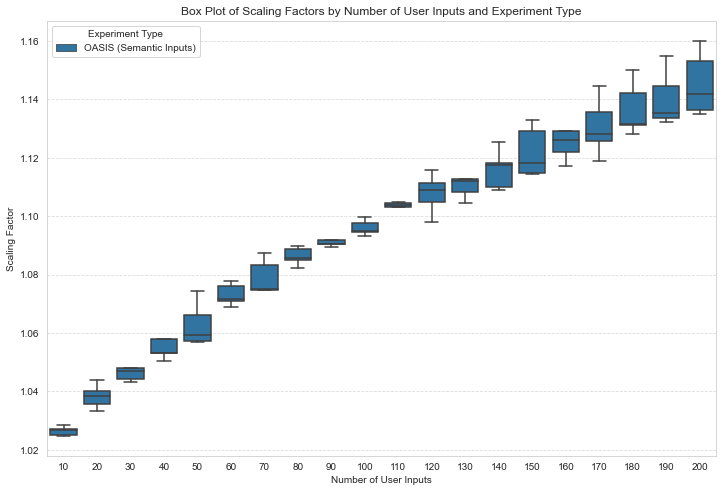

In [27]:
# Convert 'Num Pairs' to a categorical variable for better grouping in Seaborn
filtered_result['Scaling Factor'] = pd.to_numeric(filtered_result['Scaling Factor'])

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=filtered_result,
    x='Num of Inputs',
    y='Scaling Factor',
    hue='Experiment Type',  # Subgroups
    showfliers=False  # Hide outliers for clearer visualization
)

# Add labels and title
plt.xlabel('Number of User Inputs')
plt.ylabel('Scaling Factor')
plt.title('Box Plot of Scaling Factors by Number of User Inputs and Experiment Type')
plt.legend(title='Experiment Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()